In [3]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
%cd ..

/Users/verajparuthi/Documents/music-prediction


In [5]:
raw_data = pd.read_csv('./resources/responses.csv')
raw_data.fillna(0, inplace=True)

In [18]:
def only_corr(x):
    if abs(x) < 0.1: return 0
    return x

In [40]:
corr = raw_data._get_numeric_data().corr().applymap(only_corr)
corr.describe()
print(len(corr))
for index, row in corr.iterrows():
    add = 0
    for col in row: 
        add += abs(col)
    if add/len(row) < 0.05:
        corr.drop(index, axis=0, inplace=True)
        corr.drop(index, axis=1, inplace=True)
corr = corr.iloc[:,:11]
corr

139


,Folk,Classical music,Musical,Pop,Metal or Hardrock,"Hiphop, Rap","Swing, Jazz",Rock n roll,Alternative,Latino,Opera
Folk,1.000000,0.357847,0.262218,0.000000,0.000000,0.000000,0.250435,0.177144,0.122640,0.231238,0.362480
Classical music,0.357847,1.000000,0.333759,0.000000,0.167499,-0.157814,0.422204,0.284242,0.289588,0.146559,0.580950
Musical,0.262218,0.333759,1.000000,0.233605,0.000000,0.000000,0.241282,0.218403,0.000000,0.370299,0.418736
Pop,0.000000,0.000000,0.233605,1.000000,-0.281890,0.287478,0.000000,0.000000,-0.201116,0.295046,0.000000
Metal or Hardrock,0.000000,0.167499,0.000000,-0.281890,1.000000,-0.196867,0.122676,0.286197,0.280648,-0.128557,0.124307
"Hiphop, Rap",0.000000,-0.157814,0.000000,0.287478,-0.196867,1.000000,0.000000,-0.111160,-0.154616,0.132657,-0.150278
"Swing, Jazz",0.250435,0.422204,0.241282,0.000000,0.122676,0.000000,1.000000,0.466177,0.332445,0.299363,0.309998
Rock n roll,0.177144,0.284242,0.218403,0.000000,0.286197,-0.111160,0.466177,1.000000,0.410342,0.186790,0.193283
Alternative,0.122640,0.289588,0.000000,-0.201116,0.280648,-0.154616,0.332445,0.410342,1.000000,0.000000,0.153708
Latino,0.231238,0.146559,0.370299,0.295046,-0.128557,0.132657,0.299363,0.186790,0.000000,1.000000,0.186312


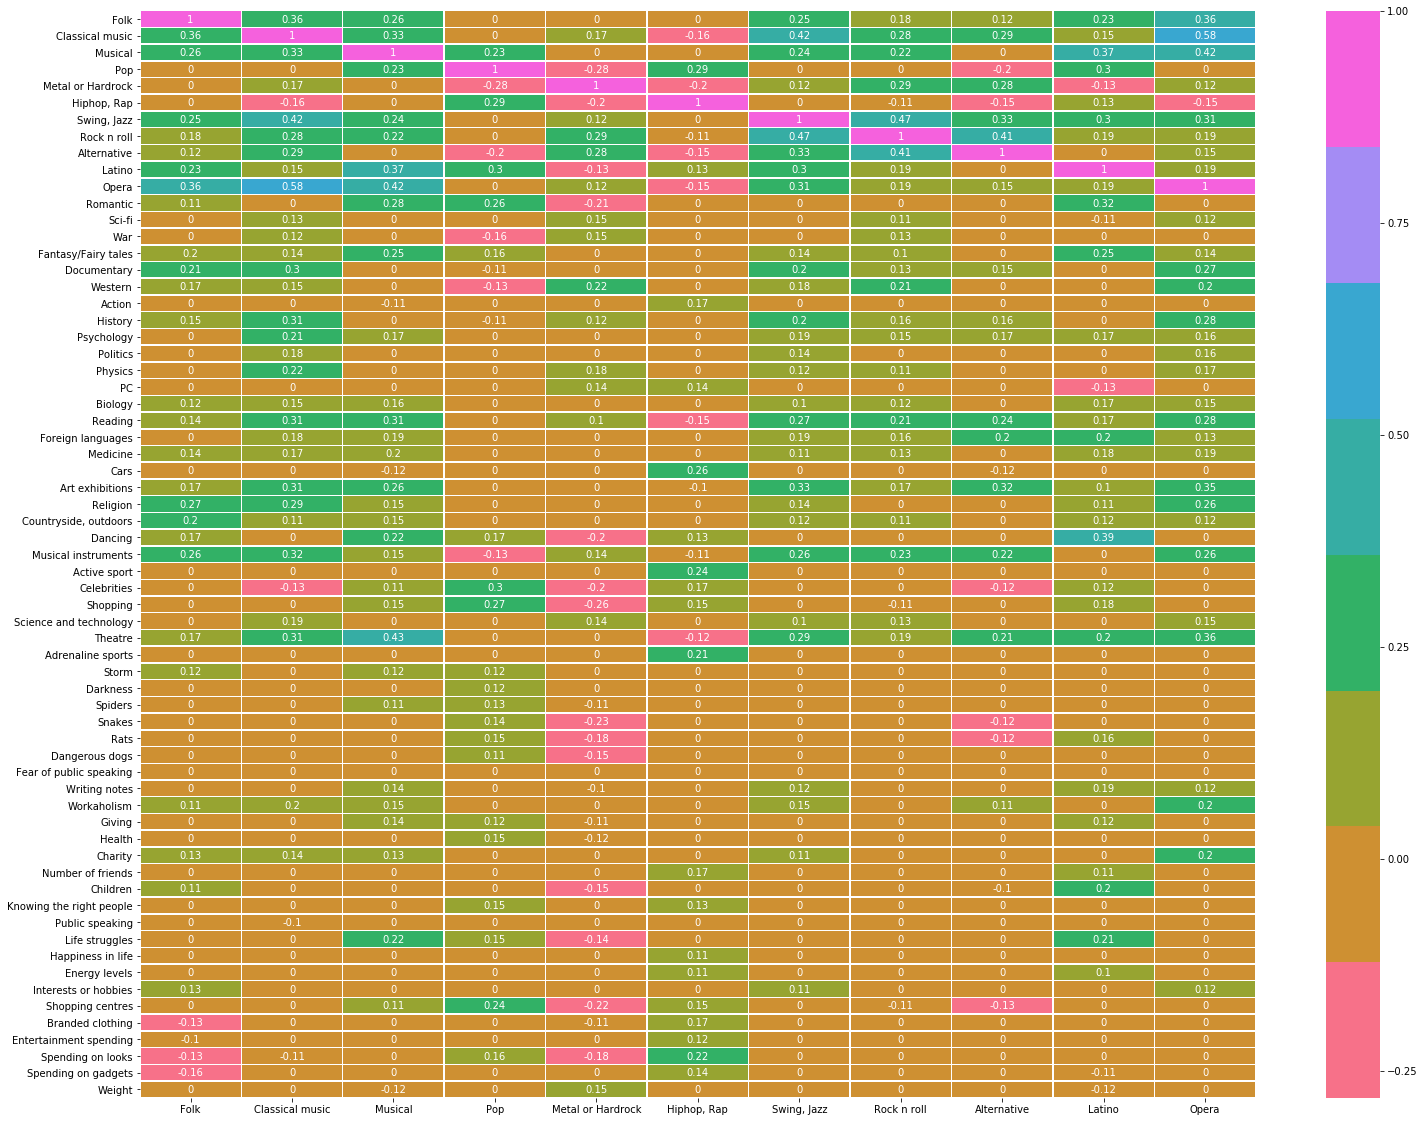

In [47]:
plt.figure(figsize=(25,20))
sns.heatmap(corr, cmap= sns.color_palette("husl",8), annot=True, linewidth=0.5)


In [19]:
music = raw_data.iloc[:,:19]
music = music[['Country', 'Classical music', 'Pop', 'Rock', 'Hiphop, Rap', 'Alternative']].astype(int)
movie = raw_data.iloc[:,19:31].astype(int)
hobbies = raw_data.iloc[:,31:63].astype(int)
phobias = raw_data.iloc[:,63:73].astype(int)
health = pd.get_dummies(raw_data.iloc[:,73:76],drop_first=True).astype(int)
traits = pd.get_dummies(raw_data.iloc[:,76:133],drop_first=True).astype(int)
habits = pd.get_dummies(raw_data.iloc[:,133:120],drop_first=True).astype(int)


[0         never smoked
1         never smoked
2        tried smoking
3        former smoker
4        tried smoking
5         never smoked
6        tried smoking
7       current smoker
8        tried smoking
9         never smoked
10      current smoker
11       tried smoking
12       tried smoking
13        never smoked
14      current smoker
15       former smoker
16      current smoker
17       tried smoking
18       tried smoking
19       former smoker
20        never smoked
21       tried smoking
22       tried smoking
23       tried smoking
24       tried smoking
25       tried smoking
26       tried smoking
27        never smoked
28       former smoker
29       tried smoking
             ...      
980                  0
981      tried smoking
982      tried smoking
983      tried smoking
984     current smoker
985      former smoker
986      tried smoking
987     current smoker
988      tried smoking
989      former smoker
990      former smoker
991      tried smoking
992       

In [60]:
music.describe()

,Country,Classical music,Pop,Rock,"Hiphop, Rap",Alternative,"Reggae, Ska"
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,2.112871,2.935644,3.461386,3.739604,2.899010,2.808911,2.750495
std,1.083772,1.272106,1.174976,1.216225,1.385075,1.362866,1.231855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000
75%,3.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [211]:
raw_data.iloc[:,19:]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,5.0,5.0,3.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,5.0,2.0,2.0,4.0,3.0,4.0,1.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,3.0,4.0,4.0,2.0,4.0,2.0,5.0,5.0,2.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,4.0,4.0,3.0,3.0,4.0,3.0,1.0,2.0,5.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,4.0,4.0,5.0,2.0,3.0,3.0,4.0,4.0,3.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
5,5.0,5.0,5.0,5.0,2.0,3.0,3.0,4.0,3.0,3.0,...,20.0,186.0,77.0,1.0,male,right handed,secondary school,no,city,block of flats
6,4.0,2.0,1.0,5.0,3.0,1.0,3.0,5.0,5.0,3.0,...,20.0,177.0,50.0,1.0,female,right handed,secondary school,no,village,house/bungalow
7,5.0,4.0,4.0,5.0,2.0,3.0,3.0,4.0,4.0,3.0,...,19.0,184.0,90.0,1.0,male,right handed,college/bachelor degree,no,city,house/bungalow
8,5.0,1.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,...,18.0,166.0,55.0,1.0,female,right handed,secondary school,no,city,house/bungalow
9,5.0,2.0,1.0,5.0,5.0,1.0,3.0,4.0,4.0,4.0,...,19.0,174.0,60.0,3.0,female,right handed,secondary school,no,city,block of flats


In [ ]:
raw_data.iloc[:,]

In [170]:
questions = raw_data[['Criminal damage', 'Adrenaline sports', 'Passive sport', 'Waiting', 'Eating to survive', 'Friends versus money', 'Cheating in school']].astype(int)



In [171]:
general = raw_data[['Age', 'Gender']]
general['Gender'] = general['Gender'].apply(lambda row: 0 if row == 'female' else 1)
general = general.astype(int)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [202]:
music = raw_data[['Country', 'Classical music', 'Pop', 'Rock', 'Hiphop, Rap', 'Alternative', 'Loneliness', 'God']].astype(int)
for col in music:
    median = music[col].median()
    music[col] = music[col].apply(lambda row: 1 if row > median else 0)
data = questions.join(general)

In [203]:

X_train, X_test, y_train, y_test = train_test_split(data, music, test_size=0.33, random_state=42)

In [204]:
X_train

,Criminal damage,Adrenaline sports,Passive sport,Waiting,Eating to survive,Friends versus money,Cheating in school,Age,Gender
758,5,4,5,2,3,3,4,20,1
499,1,1,4,4,5,3,5,22,1
0,1,4,1,3,1,3,2,20,0
316,4,4,4,3,2,3,5,20,0
713,1,2,3,4,1,5,5,19,0
551,2,1,5,3,1,5,5,16,0
803,5,5,0,2,1,3,5,27,0
536,5,5,5,1,2,3,5,19,0
745,3,3,3,3,2,0,3,25,1
845,4,2,2,3,2,5,5,20,0


In [126]:
import scipy
print(scipy.sparse.csr_matrix(y_train.values).shape)


(676, 6)


In [185]:
np.asarray(data)

array([[ 1,  4,  1, ...,  2, 20,  0],
       [ 1,  2,  1, ...,  4, 19,  0],
       [ 1,  5,  5, ...,  3, 20,  0],
       ...,
       [ 5,  1,  2, ...,  5, 18,  0],
       [ 1,  1,  2, ...,  5, 25,  0],
       [ 2,  2,  5, ...,  2, 21,  1]])

In [ ]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV


parameters = {'k': range(2,30,2), 's': [0.5, 0.7, 1.0]}
score = 'f1_micro'

In [215]:


# clf = GridSearchCV(MLkNN(), parameters, scoring=score, n_jobs=-1)
# clf.fit(data, scipy.sparse.csr_matrix(music.values))
# print(clf.best_params_, clf.best_score_)

clf = MLkNN(k=2, s=0.5)
clf.fit(data, scipy.sparse.csr_matrix(music.values))
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions)

0.16467065868263472

In [193]:
music.head()

,Country,Classical music,Pop,Rock,"Hiphop, Rap",Alternative
0,0,0,1,1,0,0
1,0,0,0,1,0,1
2,1,1,0,1,0,1
3,0,0,0,0,0,1
4,0,1,1,0,1,0


In [191]:
data.head()

,Criminal damage,Adrenaline sports,Passive sport,Waiting,Eating to survive,Friends versus money,Cheating in school,Age,Gender
0,1,4,1,3,1,3,2,20,0
1,1,2,1,3,1,4,4,19,0
2,1,5,5,2,5,5,3,20,0
3,5,1,1,1,1,2,5,22,0
4,1,2,3,3,1,3,5,20,0


In [198]:
print(clf.predict(np.asarray([[2,3,4,3,0,4,2,20,1]])))

  (0, 1)	1
  (0, 3)	1
  (0, 5)	1


In [49]:
def train_clfs(X_train, y_train, X_test, y_test):
    clfs = {
        "Knn": KNeighborsClassifier(n_neighbors=10),
        "RandomForest":RandomForestClassifier(n_estimators=50),
        "ID3" : DecisionTreeClassifier(criterion='entropy'),
        "CART" : DecisionTreeClassifier()
    }
    
    for clf_name in clfs:
        clf = clfs[clf_name]
        clf = clf.fit(X_train, y_train)
        predicted = clf.predict(X_test)
        print (i," Accuracy Score: ",accuracy_score(y_test, predicted))

In [50]:
train_clfs(X_train, X_test, y_train, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [676, 334]